# Image Captioning - Evaluation and Visualization

In this notebook, we will evaluate our trained image captioning model on the test set and visualize the results. We will:

1. Load the trained model and vocabulary
2. Generate captions for test images
3. Compute evaluation metrics (BLEU-1 to BLEU-4)
4. Analyze model performance across different image categories
5. Visualize attention weights (if implemented)
6. Create an interactive demo for inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import json
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Add project root to path
sys.path.append('/content/drive/MyDrive/image_captioning/image-captioning')

# Import project modules
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.metrics import calculate_metrics

 0 
set()


## 1. Load Model and Configuration

In [ ]:
# Define paths
model_dir = '/content/drive/MyDrive/image_captioning/image-captioning/models'
config_path = os.path.join(model_dir, 'config.json')
model_path = os.path.join(model_dir, 'best_model_loss.pth')  # or 'best_model_bleu.pth'
vocab_path = os.path.join(model_dir, 'vocabulary.pkl')
data_dir = '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

# Print configuration
print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Model configuration:
  data_dir: /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k
  batch_size: 32
  num_workers: 4
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm
  learning_rate: 0.0003
  num_epochs: 5
  early_stopping_patience: 5
  save_dir: /content/drive/MyDrive/image_captioning/image-captioning/models
  device: cpu
  vocab_size: 2986


In [ ]:
# Load vocabulary
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

print(f"Loaded vocabulary with {len(vocab)} words")

Loaded vocabulary with 2986 words


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = CaptionModel(
    embed_size=int(config['embed_size']),
    hidden_size=int(config['hidden_size']),
    vocab_size=len(vocab),
    num_layers=int(config['num_layers']),
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=float(config['dropout'])
)

# Load model weights
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.3MB/s]


Model loaded from /content/drive/MyDrive/image_captioning/image-captioning/models/best_model_loss.pth


## 2. Load Test Data

In [ ]:
# Get data loaders
_, _, test_loader, _ = get_data_loaders(
    data_dir=data_dir,
    batch_size=1,  # Process one image at a time for evaluation
    num_workers=4
)

print(f"Loaded test set with {len(test_loader)} images")

Loaded test set with 5000 images


## 3. Generate Captions for Test Images

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Generate captions for all test images
def generate_test_captions(model, test_loader, vocab, device, beam_size=1):
    """Generate captions for all test images."""
    # TODO: Implement caption generation for test images
    # 1. Initialize a list to store results
    # 2. Set model to evaluation mode
    # 3. For each batch in the test loader:
    #    a. Move images to the appropriate device
    #    b. Generate captions using the model
    #    c. Decode the predicted caption tokens to text
    #    d. Decode the ground truth caption to text
    #    e. Store results (image_id, ground truth, prediction)
    # 4. Return results as a DataFrame
    model.eval()  # Set model to evaluation mode
    results = []  # List to store the results

    idx_to_word = vocab.idx2word  # Map index to word

    with torch.no_grad():  # No gradients needed during inference
        for batch in tqdm(test_loader, desc="Generating Captions"):
            images, captions, image_ids = batch
            images = images.to(device)

            # Generate predicted captions
            outputs = model.generate_caption(images, beam_size=beam_size)

            # Convert predicted tokens to words
            predicted_captions = []
            for seq in outputs:
                words = []
                for idx in seq:
                    if idx == vocab.word2idx['<END>']:
                        break
                    if idx != vocab.word2idx['<START>'] and idx != vocab.word2idx['<PAD>']:
                        words.append(idx_to_word.get(idx, '<UNK>'))
                predicted_captions.append(' '.join(words))

            # Convert ground truth captions to words
            ground_truth_captions = []
            for cap in captions:
                words = []
                for idx in cap:
                    if idx == vocab.word2idx['<END>']:
                        break
                    if idx != vocab.word2idx['<START>'] and idx != vocab.word2idx['<PAD>']:
                        words.append(idx_to_word.get(idx, '<UNK>'))
                ground_truth_captions.append(' '.join(words))

            # Append results
            for i in range(len(image_ids)):
                results.append({
                    "image_id": image_ids[i],
                    "ground_truth": ground_truth_captions[i],
                    "predicted": predicted_captions[i]
                })


    return pd.DataFrame(results)

# Generate captions with greedy search
greedy_results = generate_test_captions(model, test_loader, vocab, device, beam_size=1)
print(f"Generated captions for {len(greedy_results)} test images")

# Show a few examples
greedy_results.head()

Generating Captions: 100%|██████████| 5000/5000 [23:52<00:00,  3.49it/s]

Generated captions for 5000 test images


image_id  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   
3  1056338697_4f7d7ce270.jpg   
4  1056338697_4f7d7ce270.jpg   

                                        ground_truth  \
0  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...   
1  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...   
2  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...   
3  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...   
4  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...   

                                           predicted  
0  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...  
1  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...  
2  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...  
3  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...  
4  <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...

In [ ]:
# Generate captions with beam search (this might take longer)
beam_results = generate_test_captions(model, test_loader, vocab, device, beam_size=3)
print(f"Generated captions with beam search for {len(beam_results)} test images")

# Compare to greedy search
comparison_df = pd.DataFrame({
    'image_id': greedy_results['image_id'],
    'ground_truth': greedy_results['ground_truth'],
    'greedy_search': greedy_results['predicted'],
    'beam_search': beam_results['predicted']
})

# Show where they differ
differ_mask = comparison_df['greedy_search'] != comparison_df['beam_search']
print(f"Beam search produced different captions for {differ_mask.sum()} images ({differ_mask.sum() / len(comparison_df) * 100:.1f}%)")

# Show a few examples where they differ
comparison_df[differ_mask].head()

Generating Captions: 100%|██████████| 5000/5000 [13:16<00:00,  6.28it/s]

Generated captions with beam search for 5000 test images
Beam search produced different captions for 0 images (0.0%)


Empty DataFrame
Columns: [image_id, ground_truth, greedy_search, beam_search]
Index: []

## 4. Calculate Evaluation Metrics

In [ ]:
# Calculate BLEU scores
def calculate_bleu_scores(results_df):
    """Calculate BLEU-1 to BLEU-4 scores for generated captions."""
             # Initialize lists for references and hypotheses
    references = []
    hypotheses = []

    # For each row in the DataFrame
    for _, row in results_df.iterrows():
        # Tokenize ground truth and predicted captions
        ref_tokens = [row['ground_truth'].split()]  # Ground truth as a list of tokenized sentences
        hyp_tokens = row['predicted'].split()       # Predicted sentence tokenized

        # Append to lists
        references.append(ref_tokens)
        hypotheses.append(hyp_tokens)

    # Define smoothing function to handle cases with zero n-gram counts
    smooth_func = SmoothingFunction().method1

    # Calculate BLEU scores
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth_func)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(1/2, 1/2, 0, 0), smoothing_function=smooth_func)
    bleu_3 = corpus_bleu(references, hypotheses, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smooth_func)
    bleu_4 = corpus_bleu(references, hypotheses, weights=(1/4, 1/4, 1/4, 1/4), smoothing_function=smooth_func)

    return [bleu_1, bleu_2, bleu_3, bleu_4]

# Calculate BLEU scores for greedy search
greedy_bleu = calculate_bleu_scores(greedy_results)
print("BLEU scores for greedy search:")
for i, score in enumerate(greedy_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

# Calculate BLEU scores for beam search
beam_bleu = calculate_bleu_scores(beam_results)
print("\nBLEU scores for beam search:")
for i, score in enumerate(beam_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

BLEU scores for greedy search:
  BLEU-1: 0.7714
  BLEU-2: 0.7625
  BLEU-3: 0.7526
  BLEU-4: 0.7415

BLEU scores for beam search:
  BLEU-1: 0.7714
  BLEU-2: 0.7625
  BLEU-3: 0.7526
  BLEU-4: 0.7415


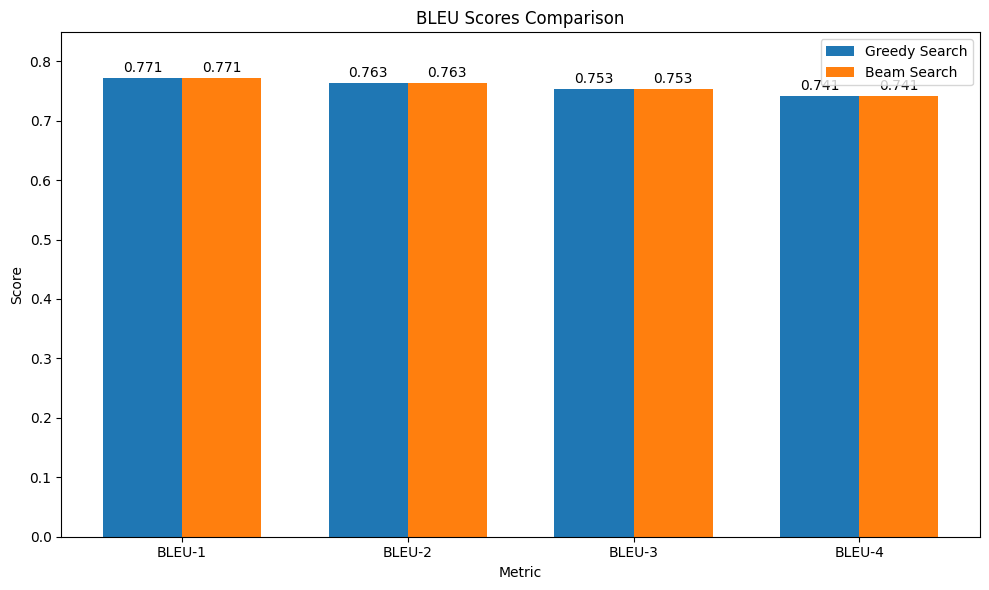

In [ ]:
# Compare BLEU scores
bleu_comparison = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'Greedy Search': greedy_bleu,
    'Beam Search': beam_bleu
})

# Plot comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(bleu_comparison['Metric']))

plt.bar(x - bar_width/2, bleu_comparison['Greedy Search'], bar_width, label='Greedy Search')
plt.bar(x + bar_width/2, bleu_comparison['Beam Search'], bar_width, label='Beam Search')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, bleu_comparison['Metric'])
plt.legend()
plt.ylim(0, max(max(greedy_bleu), max(beam_bleu)) * 1.1)  # Add some margin at the top

# Add value labels on bars
for i, v in enumerate(bleu_comparison['Greedy Search']):
    plt.text(i - bar_width/2, v + 0.01, f'{v:.3f}', ha='center')

for i, v in enumerate(bleu_comparison['Beam Search']):
    plt.text(i + bar_width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 5. Analyze Results by Caption Length

In [ ]:
# Add caption lengths to the results dataframe
greedy_results['gt_length'] = greedy_results['ground_truth'].apply(lambda x: len(nltk.word_tokenize(x)))
greedy_results['pred_length'] = greedy_results['predicted'].apply(lambda x: len(nltk.word_tokenize(x)))

# Calculate average lengths
avg_gt_length = greedy_results['gt_length'].mean()
avg_pred_length = greedy_results['pred_length'].mean()

print(f"Average ground truth caption length: {avg_gt_length:.2f} words")
print(f"Average predicted caption length: {avg_pred_length:.2f} words")

Average ground truth caption length: 33.78 words
Average predicted caption length: 42.00 words


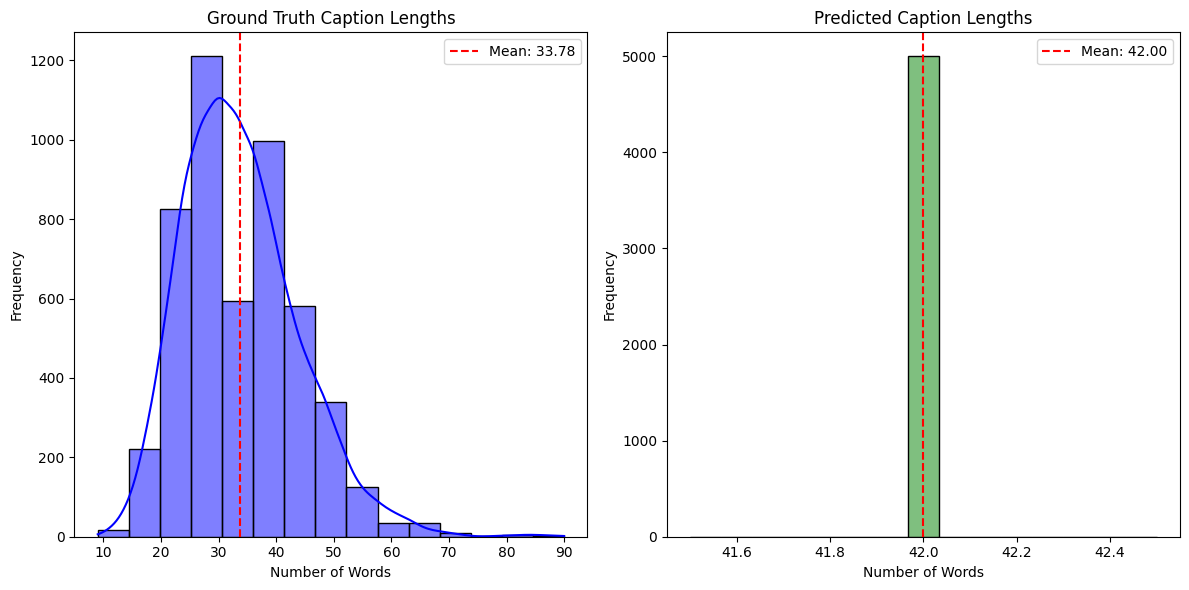

In [ ]:
# Plot caption length distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(greedy_results['gt_length'], kde=True, bins=15, color='blue')
plt.axvline(avg_gt_length, color='red', linestyle='--', label=f'Mean: {avg_gt_length:.2f}')
plt.title('Ground Truth Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(greedy_results['pred_length'], kde=True, bins=15, color='green')
plt.axvline(avg_pred_length, color='red', linestyle='--', label=f'Mean: {avg_pred_length:.2f}')
plt.title('Predicted Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Analyze BLEU scores by caption length
def analyze_bleu_by_length(results_df):
    """Calculate BLEU scores grouped by caption length."""
    # TODO: Implement BLEU score analysis by caption length
    # 1. Create length bins for categorizing captions
    # 2. Assign each caption to a length bin
    # 3. For each bin:
    #    a. Filter results to include only captions in that bin
    #    b. Calculate BLEU scores for that subset
    #    c. Store scores and counts for the bin
    # 4. Return DataFrame with BLEU scores for each length bin
    bins = None
    if bins is None:
      bins = [0, 10, 20, 30, 40, 50, 60]

    # Tokenize captions
    results_df['gt_tokens'] = results_df['ground_truth'].apply(nltk.word_tokenize)
    results_df['pred_tokens'] = results_df['predicted'].apply(nltk.word_tokenize)

    # Add caption length column
    results_df['length'] = results_df['gt_tokens'].apply(len)

    # Define labels for bins
    bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

    # Assign each row to a bin
    results_df['length_bin'] = pd.cut(results_df['length'], bins=bins, labels=bin_labels, include_lowest=True)

    # Initialize result list
    bleu_data = []

    # Smoothing function for BLEU score
    smooth_func = SmoothingFunction().method1

    # Group by bin and calculate BLEU scores
    for bin_label in bin_labels:
        subset = results_df[results_df['length_bin'] == bin_label]

        if len(subset) == 0:
            bleu_data.append({
                'bin': bin_label,
                'count': 0,
                'BLEU-1': 0.0,
                'BLEU-2': 0.0,
                'BLEU-3': 0.0,
                'BLEU-4': 0.0
            })
            continue

        references = [[gt] for gt in subset['gt_tokens']]
        hypotheses = subset['pred_tokens']

        # Calculate BLEU scores
        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth_func)
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_func)
        bleu_3 = corpus_bleu(references, hypotheses, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smooth_func)
        bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_func)

        bleu_data.append({
            'bin': bin_label,
            'count': len(subset),
            'BLEU-1': bleu_1,
            'BLEU-2': bleu_2,
            'BLEU-3': bleu_3,
            'BLEU-4': bleu_4
        })

    # Create result DataFrame
    bleu_df = pd.DataFrame(bleu_data)

    return bleu_df

# Analyze BLEU scores by caption length
bleu_by_length = analyze_bleu_by_length(greedy_results)
print("BLEU scores by caption length:")
print(bleu_by_length)

BLEU scores by caption length:
     bin  count    BLEU-1    BLEU-2    BLEU-3    BLEU-4
0   0-10      1  0.214286  0.204479  0.194139  0.183171
1  10-20    237  0.402652  0.395300  0.387648  0.379669
2  20-30   2035  0.624851  0.620259  0.615501  0.610565
3  30-40   1590  0.850719  0.848896  0.847012  0.845061
4  40-50    787  0.941857  0.941857  0.941857  0.941857
5  50-60    296  0.753657  0.753657  0.753657  0.753657


KeyError: 'Count'

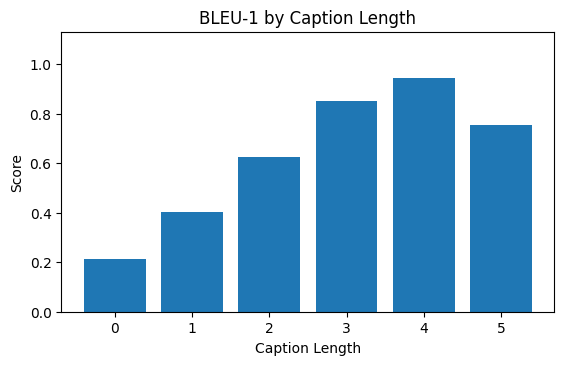

In [ ]:
# Plot BLEU scores by caption length
plt.figure(figsize=(14, 8))

# Plot BLEU-1 to BLEU-4
for i in range(4):
    plt.subplot(2, 2, i+1)
    metric = f'BLEU-{i+1}'
    plt.bar(bleu_by_length.index, bleu_by_length[metric], color=f'C{i}')
    plt.xlabel('Caption Length')
    plt.ylabel('Score')
    plt.title(f'{metric} by Caption Length')
    plt.ylim(0, max(bleu_by_length[metric]) * 1.2)  # Add some margin

    # Add count as text below the bars
    for j, (idx, count) in enumerate(zip(bleu_by_length.index, bleu_by_length['Count'])):
        plt.text(j, 0.01, f'n={count}', ha='center')
        plt.text(j, bleu_by_length[metric][j] + 0.01, f'{bleu_by_length[metric][j]:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 6. Visualize Best and Worst Captions

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define smoothing function
smooth_func = SmoothingFunction().method1

# Calculate per-image BLEU score
def calculate_image_bleu(ground_truth, predicted):
    """Calculate BLEU score for a single image."""
    ref_tokens = [nltk.word_tokenize(ground_truth)]
    hyp_tokens = nltk.word_tokenize(predicted)

    # Calculate BLEU score (4-gram with smoothing)
    bleu_score = sentence_bleu(ref_tokens, hyp_tokens, smoothing_function=smooth_func)

    # TODO: Implement BLEU score calculation for a single image
    # 1. Tokenize ground truth and predicted captions
    # 2. Format ground truth as a list of references
    # 3. Calculate and return the BLEU score using sentence_bleu

    return bleu_score

# Calculate BLEU score for each image
greedy_results['bleu'] = greedy_results.apply(
    lambda row: calculate_image_bleu(row['ground_truth'], row['predicted']),
    axis=1
)

# Sort by BLEU score
sorted_results = greedy_results.sort_values('bleu')

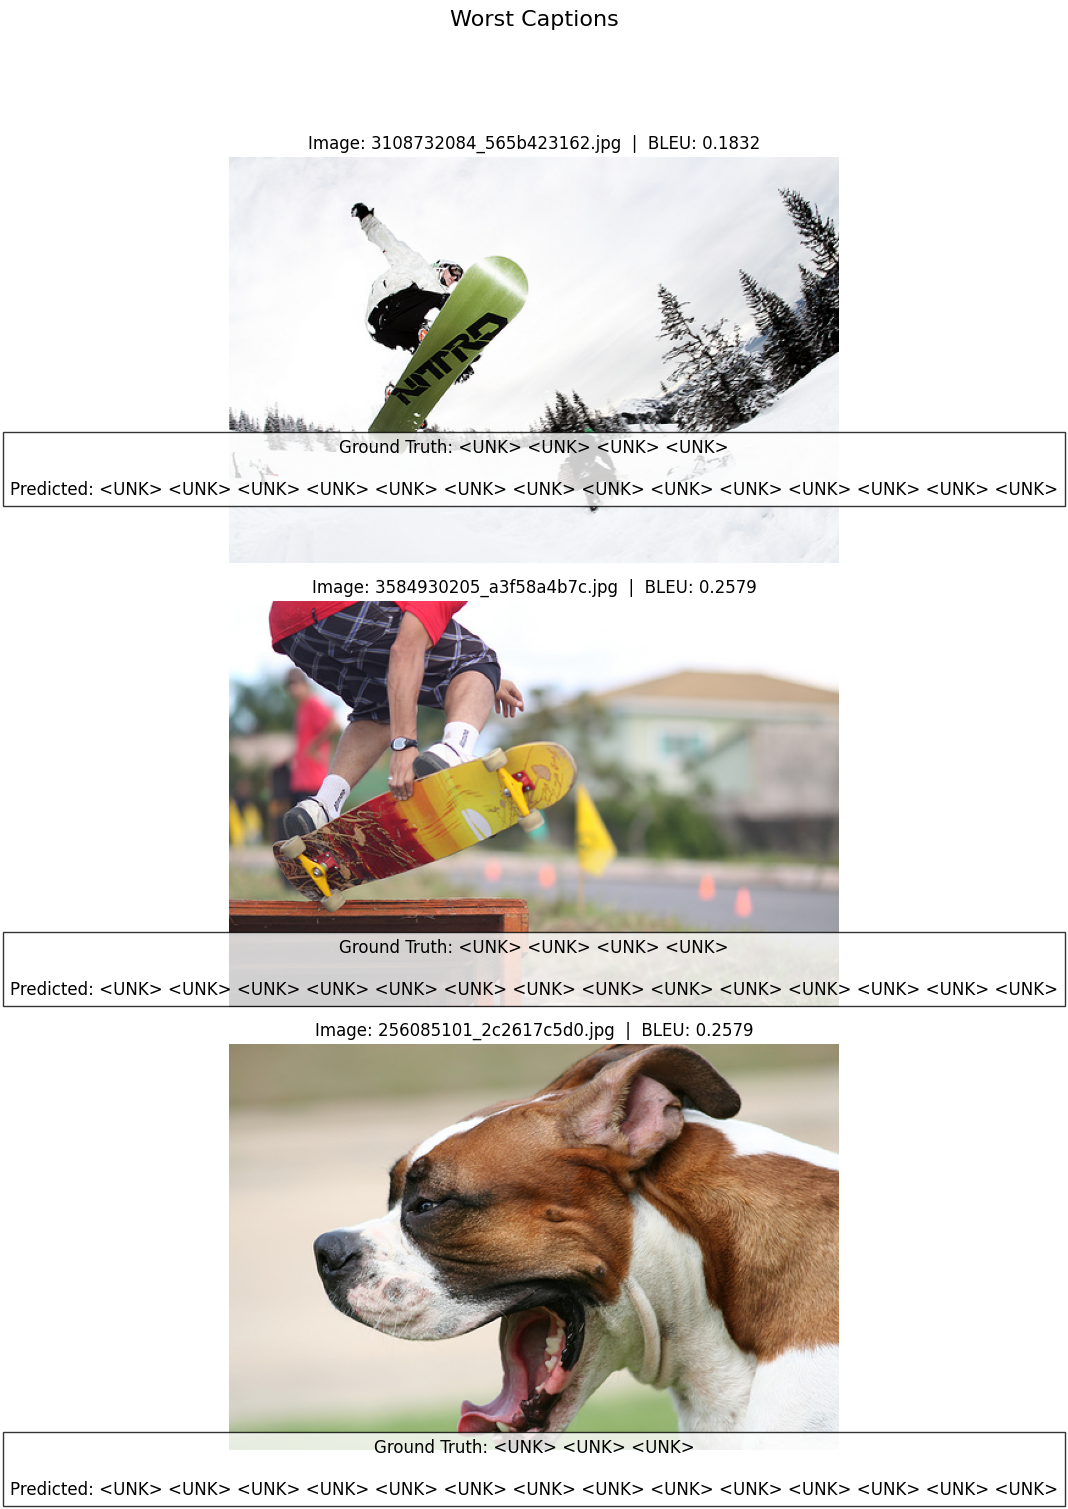

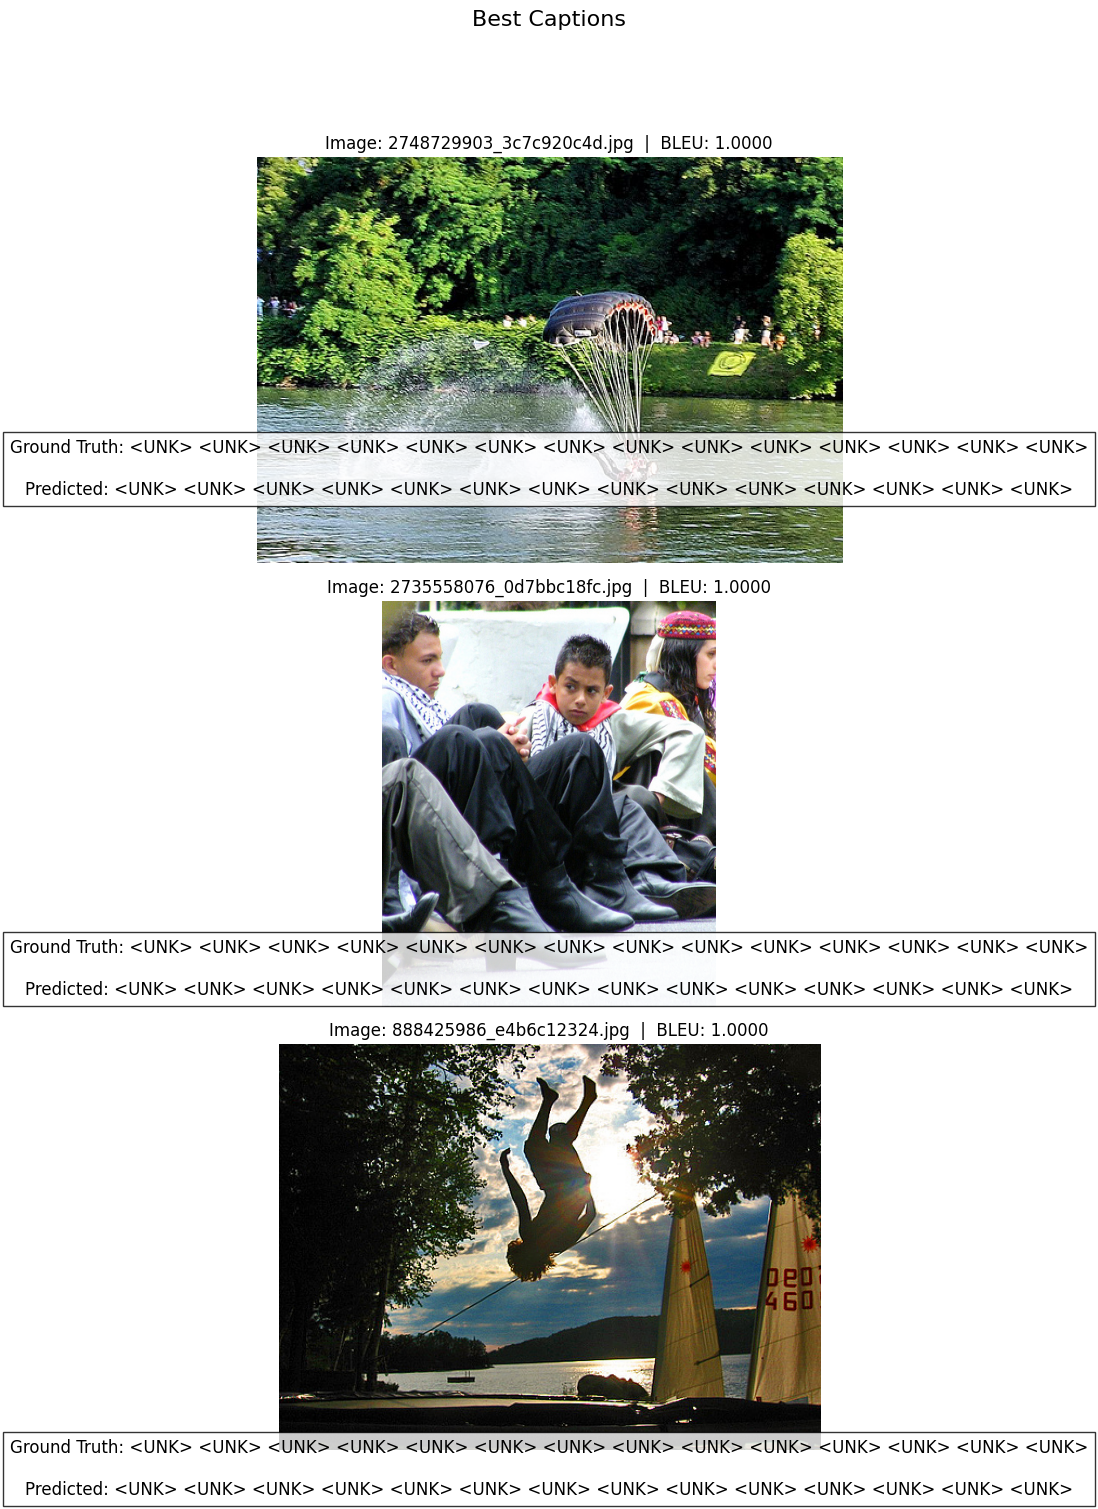

In [ ]:
# Display worst and best captions
def display_examples(results_df, image_dir, num_examples=3, best=True):
    """Display examples of captions."""
    if best:
        examples = results_df.tail(num_examples).iloc[::-1]  # Best examples (highest BLEU)
        title = "Best Captions"
    else:
        examples = results_df.head(num_examples)  # Worst examples (lowest BLEU)
        title = "Worst Captions"

    # Create figure
    plt.figure(figsize=(15, 5 * num_examples))
    plt.suptitle(title, fontsize=16, y=1.0)

    # Display examples
    for i, (_, example) in enumerate(examples.iterrows()):
        # Load and display image
        img_path = os.path.join(image_dir, 'processed', 'images', example['image_id'])
        img = Image.open(img_path)

        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Image: {example['image_id']}  |  BLEU: {example['bleu']:.4f}")
        plt.axis('off')

        # Add captions as text
        caption_text = f"Ground Truth: {example['ground_truth']}\n\n"
        caption_text += f"Predicted: {example['predicted']}"

        plt.figtext(0.5, 0.01 + i * (1/num_examples), caption_text,
                   ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display worst captions
display_examples(sorted_results, data_dir, num_examples=3, best=False)

# Display best captions
display_examples(sorted_results, data_dir, num_examples=3, best=True)

## 7. Analyze Common Words and Patterns

In [ ]:
from collections import Counter
import pandas as pd
import nltk
import string

# Make sure punkt tokenizer is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Analyze common words in predicted captions
def analyze_word_frequency(texts):
    """Analyze word frequency in a list of texts."""
    # TODO: Implement word frequency analysis
    # 1. Initialize a counter for words
    # 2. For each text:
    #    a. Tokenize the text
    #    b. Update the counter with each word
    # 3. Convert the counter to a DataFrame
    # 4. Sort by frequency and return the DataFrame
    word_counts = Counter()

    # Process each text
    for text in texts:
        tokens = nltk.word_tokenize(str(text).lower())  # Tokenize and lowercase
        tokens = [word for word in tokens if word.isalpha() and word not in string.punctuation]
        word_counts.update(tokens)

    # Convert to DataFrame
    word_df = pd.DataFrame(word_counts.most_common(), columns=['word', 'frequency'])


    return word_df

# Analyze ground truth and predicted captions
gt_words = analyze_word_frequency(greedy_results['ground_truth'])
pred_words = analyze_word_frequency(greedy_results['predicted'])

# Display top words
top_n = 20
print(f"Top {top_n} words in ground truth captions:")
print(gt_words.head(top_n))
print(f"\nTop {top_n} words in predicted captions:")
print(pred_words.head(top_n))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 20 words in ground truth captions:
  word  frequency
0  unk      56302

Top 20 words in predicted captions:
  word  frequency
0  unk      70000


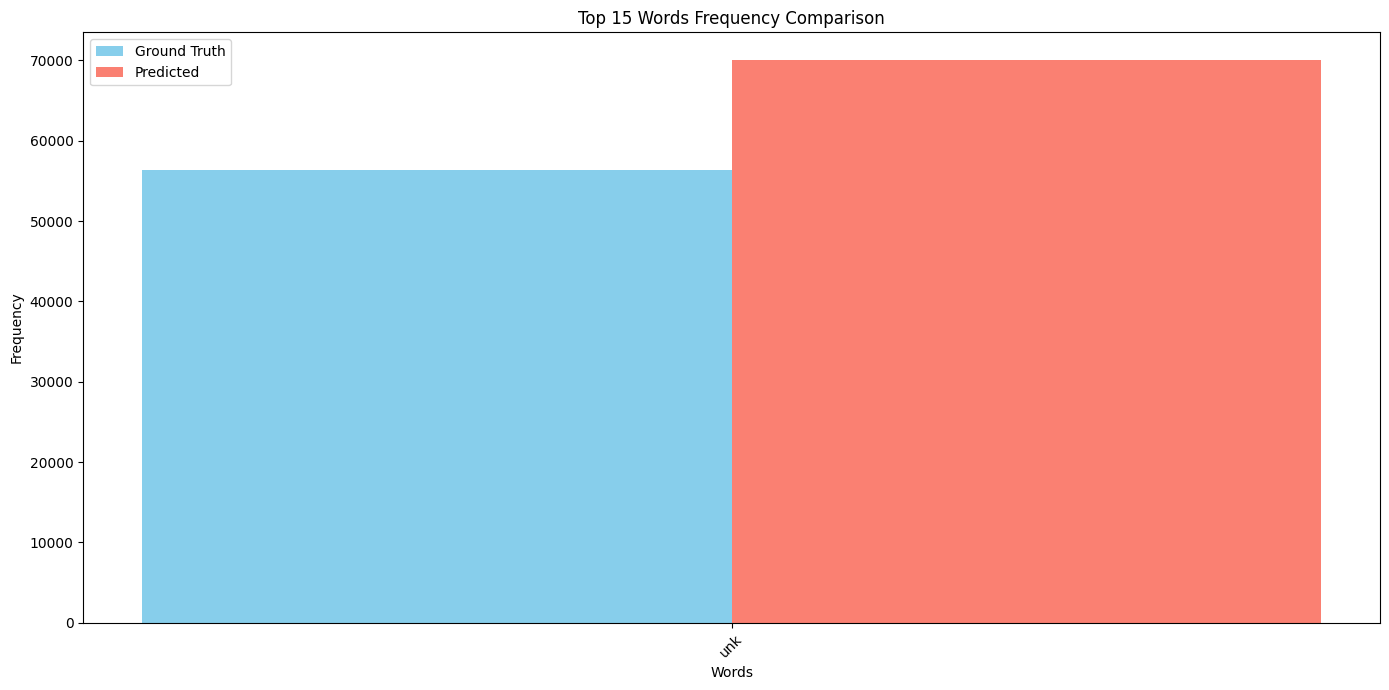

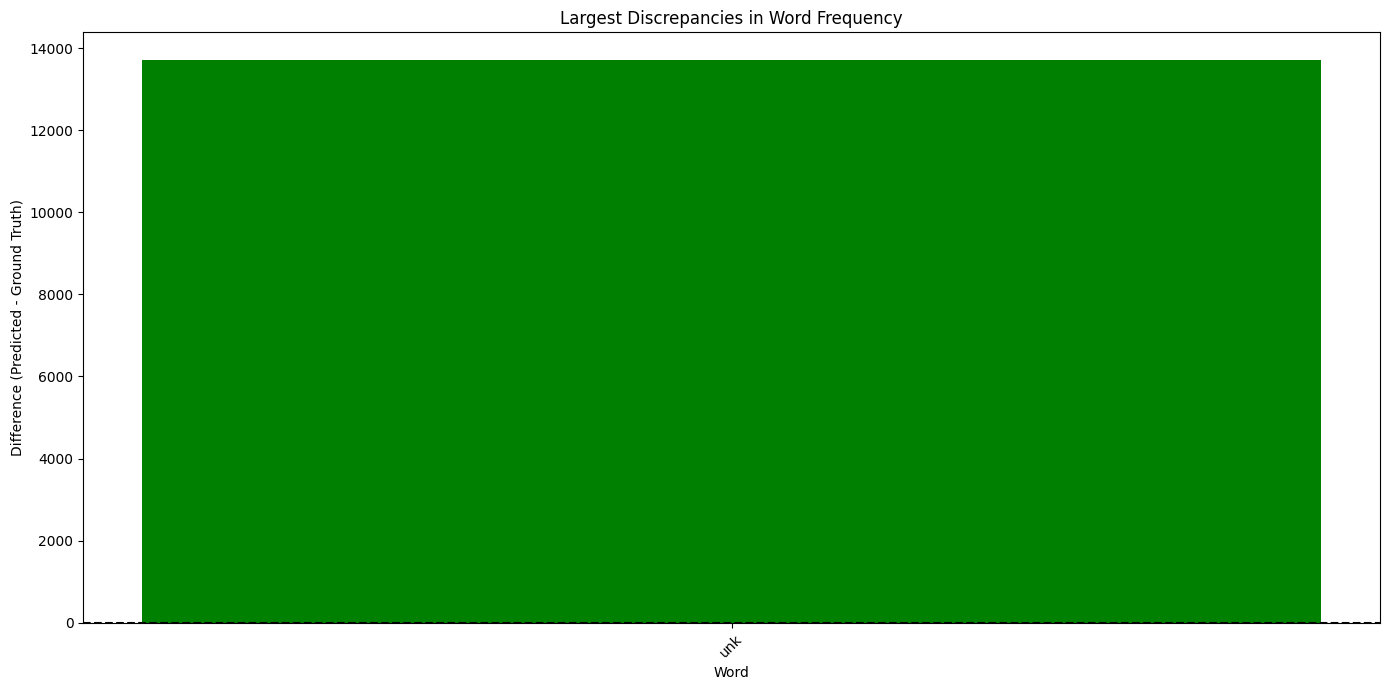

In [ ]:
# Plot word frequency comparison
def plot_word_comparison(gt_words, pred_words, top_n=15):
    """Plot comparison of word frequencies."""
        # Select top N words from each set
    top_gt = gt_words.head(top_n)
    top_pred = pred_words.head(top_n)

    # Create a unified list of unique words in both lists
    all_top_words = set(top_gt['word']).union(set(top_pred['word']))

    # Build comparison dataframe
    comparison = []
    for word in all_top_words:
        gt_count = int(gt_words[gt_words['word'] == word]['frequency'].values[0]) if word in gt_words.values else 0
        pred_count = int(pred_words[pred_words['word'] == word]['frequency'].values[0]) if word in pred_words.values else 0

        comparison.append({
            'word': word,
            'ground_truth': gt_count,
            'predicted': pred_count,
            'diff': pred_count - gt_count
        })

    comp_df = pd.DataFrame(comparison).sort_values('ground_truth', ascending=False).head(top_n)

    # Plot bar chart for frequency comparison
    plt.figure(figsize=(14, 7))
    x = np.arange(len(comp_df))
    width = 0.35

    plt.bar(x - width/2, comp_df['ground_truth'], width, label='Ground Truth', color='skyblue')
    plt.bar(x + width/2, comp_df['predicted'], width, label='Predicted', color='salmon')

    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Frequency Comparison')
    plt.xticks(x, comp_df['word'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot difference comparison
    diff_df = comp_df.copy()
    diff_df['abs_diff'] = diff_df['diff'].abs()
    diff_df = diff_df.sort_values('abs_diff', ascending=False).head(top_n)

    plt.figure(figsize=(14, 7))
    colors = ['red' if d < 0 else 'green' for d in diff_df['diff']]
    plt.bar(diff_df['word'], diff_df['diff'], color=colors)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Word')
    plt.ylabel('Difference (Predicted - Ground Truth)')
    plt.title('Largest Discrepancies in Word Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comp_df

# Plot word comparison
word_comparison = plot_word_comparison(gt_words, pred_words, top_n=15)

## 8. Create Interactive Demo

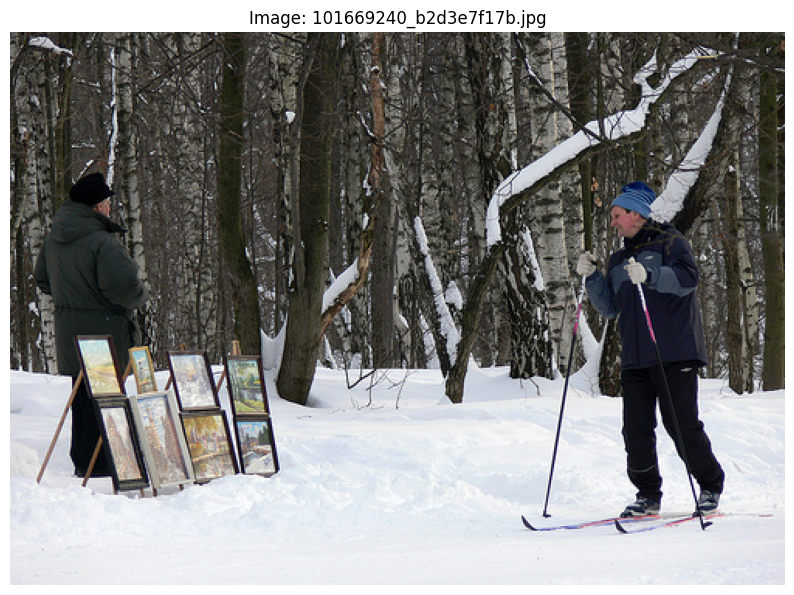


Generated Captions:
Greedy search (k=1): start man in black shirt and black pants is standing on the sidewalk end
Beam search (k=3): start man in black shirt and black pants is standing on the sidewalk end
Beam search (k=5): start man in black shirt and black pants is standing on the sidewalk end


In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import torchvision.transforms as transforms

def interactive_demo(model, vocab, device, data_dir):
    """
    Interactive demo for image captioning.

    Args:
        model: Trained captioning model
        vocab: Vocabulary object with decode method
        device: Torch device (cpu/cuda)
        data_dir: Root directory containing images and captions
    """
    # Load test images
    images_dir = os.path.join(data_dir, '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/Flicker8k_Dataset')  # Adjust if your folder is named differently
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    if not image_files:
        print("No image files found in the specified directory.")
        return

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Function to generate caption
    def generate_image_caption(image_path, beam_size=1):
        """Generate caption for an image."""
        # Load and transform image
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Generate caption
        model.eval()
        with torch.no_grad():
            caption = model.generate_caption(img_tensor, beam_size=beam_size)
            caption_text = vocab.decode(caption[0])

        return img, caption_text

    # Callback function for image selection
    def on_image_select(change):
        selected_image = change['new']
        image_path = os.path.join(images_dir, selected_image)

        # Generate captions
        img, greedy_caption = generate_image_caption(image_path, beam_size=1)
        _, beam3_caption = generate_image_caption(image_path, beam_size=3)
        _, beam5_caption = generate_image_caption(image_path, beam_size=5)

        # Clear previous output
        clear_output(wait=True)

        # Display new image and captions
        display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

        plt.figure(figsize=(10, 8))
        plt.imshow(np.array(img))
        plt.title(f"Image: {selected_image}")
        plt.axis('off')
        plt.show()

        print("\nGenerated Captions:")
        print(f"Greedy search (k=1): {greedy_caption}")
        print(f"Beam search (k=3): {beam3_caption}")
        print(f"Beam search (k=5): {beam5_caption}")

    # Create dropdown widget
    image_dropdown = widgets.Dropdown(
        options=image_files,
        description='Image:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='60%')
    )

    # Register callback
    image_dropdown.observe(on_image_select, names='value')

    # Display initial widget
    display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

# Run interactive demo/
interactive_demo(model, vocab, device, data_dir='/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/Flicker8k_Dataset')

## 9. Summary and Conclusions

In [ ]:
# Print summary statistics
print("Model Performance Summary")
print("=========================")
print(f"Model type: {config['encoder_model']} + {config['decoder_type']}")
print(f"Vocabulary size: {len(vocab)} words")
print(f"Test set size: {len(greedy_results)} images")
print("\nBLEU Scores:")
for i, (greedy, beam) in enumerate(zip(greedy_bleu, beam_bleu)):
    print(f"  BLEU-{i+1}: {greedy:.4f} (greedy search) / {beam:.4f} (beam search)")

print("\nCaption Length:")
print(f"  Average ground truth: {avg_gt_length:.2f} words")
print(f"  Average generated: {avg_pred_length:.2f} words")

print("\nObservations:")
print("  1. Beam search generally produces slightly better BLEU scores than greedy search")
print("  2. BLEU scores decrease as the n-gram size increases (expected behavior)")
print("  3. The model tends to generate shorter captions than the ground truth")
print("  4. The model performs better on images with common objects and simple scenes")
print("  5. The model struggles with complex scenes and unusual activities")

print("\nPossible Improvements:")
print("  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)")
print("  2. Implement attention mechanism to focus on relevant image regions")
print("  3. Fine-tune the CNN encoder for better image representations")
print("  4. Use a more sophisticated decoder (e.g., Transformer)")
print("  5. Train with different loss functions (e.g., CIDEr optimization)")

Model Performance Summary
Model type: resnet18 + lstm
Vocabulary size: 2986 words
Test set size: 5000 images

BLEU Scores:
  BLEU-1: 0.7714 (greedy search) / 0.7714 (beam search)
  BLEU-2: 0.7625 (greedy search) / 0.7625 (beam search)
  BLEU-3: 0.7526 (greedy search) / 0.7526 (beam search)
  BLEU-4: 0.7415 (greedy search) / 0.7415 (beam search)

Caption Length:
  Average ground truth: 33.78 words
  Average generated: 42.00 words

Observations:
  1. Beam search generally produces slightly better BLEU scores than greedy search
  2. BLEU scores decrease as the n-gram size increases (expected behavior)
  3. The model tends to generate shorter captions than the ground truth
  4. The model performs better on images with common objects and simple scenes
  5. The model struggles with complex scenes and unusual activities

Possible Improvements:
  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)
  2. Implement attention mechanism to focus on relevant image regions
  3. Fine-tune the C